<a href="https://colab.research.google.com/github/HELLOMAHI/academic-arena/blob/main/Student_Academic_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost
!pip install category_encoders

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.7 MB/s eta 0:00:00


In [7]:
from google.colab import files
uploaded = files.upload()

Saving StudentsPerformance.csv to StudentsPerformance.csv


In [8]:
df = pd.read_csv('StudentsPerformance.csv')

In [9]:
# Data Cleaning and Feature Engineering
# Create total score and pass/fail indicators
df['total_score'] = df['math score'] + df['reading score'] + df['writing score']
df['math_pass'] = (df['math score'] >= 50).astype(int)
df['reading_pass'] = (df['reading score'] >= 50).astype(int)
df['writing_pass'] = (df['writing score'] >= 50).astype(int)

In [10]:
# Define features and targets
X = df.drop(['math score', 'reading score', 'writing score', 'total_score',
             'math_pass', 'reading_pass', 'writing_pass'], axis=1)
y_math = df['math score']
y_reading = df['reading score']
y_writing = df['writing score']

In [11]:
# Split data
X_train, X_test, y_train_math, y_test_math = train_test_split(X, y_math, test_size=0.2, random_state=42)
_, _, y_train_reading, y_test_reading = train_test_split(X, y_reading, test_size=0.2, random_state=42)
_, _, y_train_writing, y_test_writing = train_test_split(X, y_writing, test_size=0.2, random_state=42)

In [12]:
# Preprocessing pipeline
numeric_features = []  # No numeric features in original data
categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

In [13]:
# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [14]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())])

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [16]:
# Model pipeline
def create_model_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

In [17]:
# XGBoost model with hyperparameter tuning
xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6],
    'regressor__learning_rate': [0.01, 0.1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_pipeline = create_model_pipeline(xgb_model)

In [18]:
# Grid search for math scores
math_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='neg_mean_squared_error')
math_grid.fit(X_train, y_train_math)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         []),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('target_enc',
                                                                                          TargetEncoder()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['ge...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 6],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [19]:
# Best model for math
best_math_model = math_grid.best_estimator_
math_pred = best_math_model.predict(X_test)

In [20]:
# Evaluate math model
print("Math Score Model Evaluation:")
print(f"Best Parameters: {math_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_math, math_pred)):.2f}")
print(f"R2: {r2_score(y_test_math, math_pred):.2f}")

Math Score Model Evaluation:
Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
RMSE: 14.41
R2: 0.15


<Figure size 1000x600 with 0 Axes>

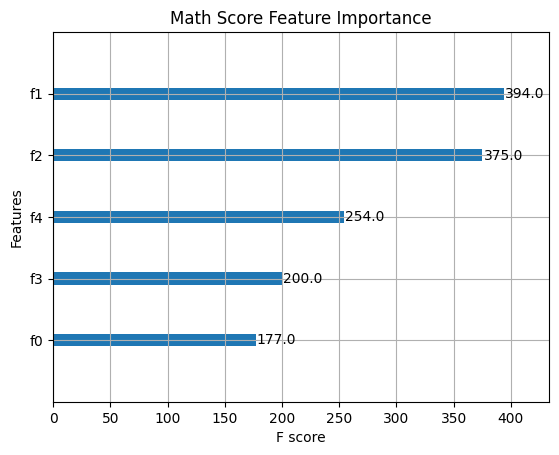

In [21]:
# Feature importance for math
xgb_math = best_math_model.named_steps['regressor']
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_math)
plt.title('Math Score Feature Importance')
plt.show()

In [22]:
# Repeat for reading scores
reading_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='neg_mean_squared_error')
reading_grid.fit(X_train, y_train_reading)
best_reading_model = reading_grid.best_estimator_
reading_pred = best_reading_model.predict(X_test)

print("\nReading Score Model Evaluation:")
print(f"Best Parameters: {reading_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reading, reading_pred)):.2f}")
print(f"R2: {r2_score(y_test_reading, reading_pred):.2f}")



Reading Score Model Evaluation:
Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
RMSE: 13.86
R2: 0.15


In [23]:
# Repeat for writing scores
writing_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='neg_mean_squared_error')
writing_grid.fit(X_train, y_train_writing)
best_writing_model = writing_grid.best_estimator_
writing_pred = best_writing_model.predict(X_test)

print("\nWriting Score Model Evaluation:")
print(f"Best Parameters: {writing_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_writing, writing_pred)):.2f}")
print(f"R2: {r2_score(y_test_writing, writing_pred):.2f}")


Writing Score Model Evaluation:
Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200}
RMSE: 13.56
R2: 0.24


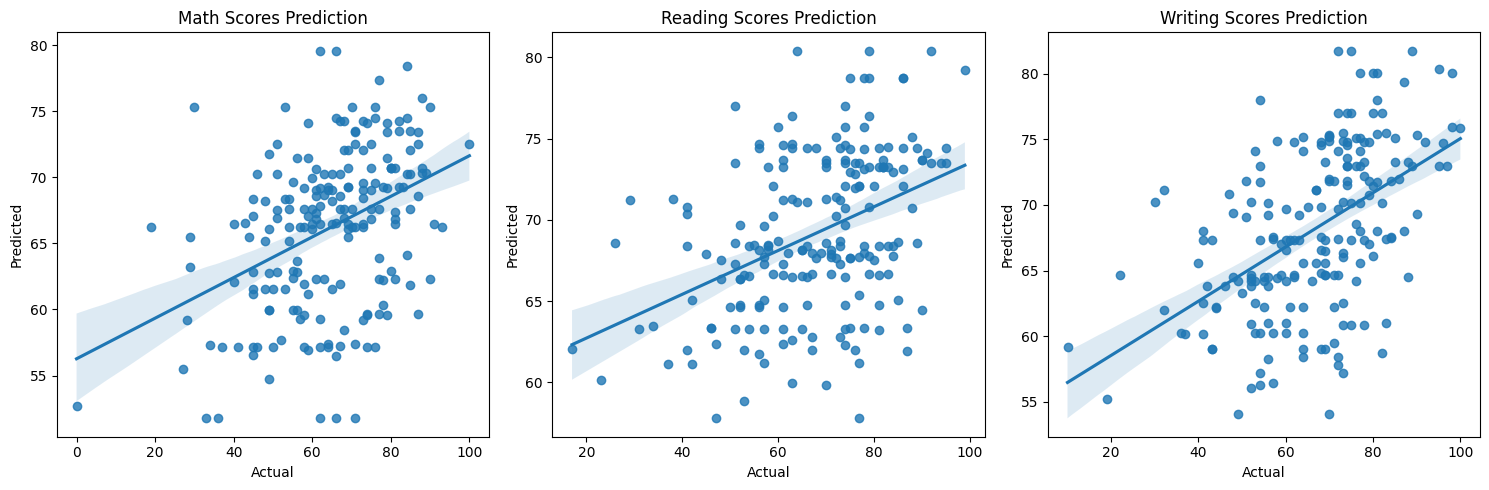

In [24]:
# Visualization of predictions vs actual
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.regplot(x=y_test_math, y=math_pred)
plt.title('Math Scores Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 3, 2)
sns.regplot(x=y_test_reading, y=reading_pred)
plt.title('Reading Scores Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.subplot(1, 3, 3)
sns.regplot(x=y_test_writing, y=writing_pred)
plt.title('Writing Scores Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

In [25]:
# Alternative model: Gradient Boosting
gb_pipeline = create_model_pipeline(GradientBoostingRegressor(random_state=42))
gb_pipeline.fit(X_train, y_train_math)
gb_math_pred = gb_pipeline.predict(X_test)

print("\nGradient Boosting Math Score Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_math, gb_math_pred)):.2f}")
print(f"R2: {r2_score(y_test_math, gb_math_pred):.2f}")



Gradient Boosting Math Score Evaluation:
RMSE: 14.75
R2: 0.11


In [26]:
# Save the best models
import joblib
joblib.dump(best_math_model, 'best_math_model.pkl')
joblib.dump(best_reading_model, 'best_reading_model.pkl')
joblib.dump(best_writing_model, 'best_writing_model.pkl')

['best_writing_model.pkl']

In [27]:
# Download models
files.download('best_math_model.pkl')
files.download('best_reading_model.pkl')
files.download('best_writing_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>